## Introduction
$\def\lex{\lambda_{ex}}$
The quantum yield of a fluorophore is defined as the number of photons the material emits for every photon that it absorbed. That is, $\Phi\equiv \dfrac{N_{em}}{N_{ab}}$. To calculate these two $N$ values, we use a Photon Technologies Internaltional fluorescence spectrometer system (PTI) to measure two emission spectra at some common excitation wavelength $\lambda_{ex}$. The first is a blank spectrum, $I_b(\lambda)$, and is taken using a cuvette filled exclusively with our solvent of choice, e.g. ethanol (EtOH), LAB. The second spectrum is taken with concentration of our fluorophore in the solvent. We label the raw emission spectrum with $I_f(\lambda)$, for fluorophore. 

These two samples must be corrected to compensate for:
1. Time-dependent variations in the PTI light source intensity (a Xenon arc lamp)
2. Wavelegnth-dependent sensitivities in the system, espectially those from the integrating sphere (IS)

Light from the arc lamp is immediately directed into a series of monochromators that only allows light to come through from a small range of wavelengths around $\lex$. The remaining light then passes through a beamsplitter. One beam goes to cuvette samples, while the other is directed to a photodiode. The resulting potential difference is measured and used to determine how the incoming intensity of light varies in time. 

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import PTI.Corrections as PTICorr
from PTI.ReadDataFiles import PTIData
import PTI.QuantumYield as PTIQY

## Helper Functions


In [ ]:
def linear_func(x, b, m):
    return m * x + b

def linear_baseline_params(PTIData, list_of_ranges):
    """ Uses a least-squared routine to fit  data to a linear function.
        The fit is performed over the given wavelength ranges.
        Returns a tuple containing: ("""

    X = np.array([])
    Y = np.array([])
    for arange in list_of_ranges:
        start = arange[0]
        end = arange[1]

        X = np.append(X, np.arange(start, end+PTIData.step_size, PTIData.step_size))

        select_by_wavelength = np.where((PTIData.wavelengths >= start) &
                                           (PTIData.wavelengths <= end))
        Y = np.append(Y, PTIData.raw_data[select_by_wavelength])

    params, cov_matrix = sp.optimize.curve_fit(linear_func, X, Y)

    return(params, cov_matrix)


def linear_baseline(PTIData, list_of_ranges,
                    use_incpt_se = 'none', use_slope_se = 'none'):
    """Uses a least-squared routine to fit  data to a polynomial of a given
        degree. The fit is performed over the given wavelength ranges.
        Returns an array with the polynomial evaluated over the full spectrum range
        with the same step size."""

    # Calculate the parameters for the fit and their standard errors. Order: (intercept, slope)
    fit_params, cov_matrix = linear_baseline_params(PTIData, list_of_ranges)
    fit_params = list(fit_params)
    # print cov_matrix
    errors = [np.sqrt(cov_matrix[0][0]), np.sqrt(cov_matrix[1][1])]

    # Use the standard errors to modify either parameter
    incpt ={'none': fit_params[0],
            'minus': fit_params[0] - errors[0],
            'plus': fit_params[0] + errors[0]}

    slope ={'none': fit_params[1],
            'minus': fit_params[1] - errors[1],
            'plus': fit_params[1] + errors[1]}

    baseline = linear_func(x=PTIData.wavelengths, m=slope[use_slope_se],b=incpt[use_incpt_se])

    # Return the baseline array as well as the fit parameters and errors.
    return baseline, fit_params, errors


def load_excorr_file(PTIData_instance, interp_method = 'cubic'):
    excorr = np.genfromtxt('PTI/correction_data/excorr.txt',
                           skip_header = 6,
                           skip_footer = 1,
                           usecols = 1)

    excorr_range = np.arange(250, 750 + 1, 1)
    ex_wavelength = PTIData_instance.ex_range[0]
    
    excorr = sp.interpolate.interp1d(excorr_range, excorr, interp_method)(ex_wavelength)
 
    return excorr

def load_emcorr_file(PTIData_instance, interp_method = 'cubic'):
    emcorr = np.genfromtxt('PTI/correction_data/emcorr-sphere-quanta.txt',
                              skip_header = 6,
                              skip_footer = 1,
                              usecols = 1)

    step = PTIData_instance.step_size
    emcorr_range = np.arange(300, 850, 2)
    xvals = np.arange(300, 848+step, step)
    
    emcorr = sp.interpolate.interp1d(emcorr_range, emcorr, interp_method)(xvals)

    min_data_wavelength = PTIData_instance.wavelengths[0]
    max_data_wavelength = PTIData_instance.wavelengths[-1]
    
    needed_wavelengths = np.where((xvals >= min_data_wavelength) & 
                                     (xvals <= max_data_wavelength))
    
    emcorr = emcorr[needed_wavelengths]
    
    return emcorr

def get_corrections(PTIData_instance):
    
    # Create a copy of the data instance
    corrections = np.ones(PTIData_instance.wavelengths.size)
    
    # Perform the diode correction made from the ExCorr RCQC signal
    corrections /= PTIData_instance.diode
    
    # Perform the LUT corrections
    corrections /= load_excorr_file(PTIData_instance=PTIData_instance)
    corrections *= load_emcorr_file(PTIData_instance=PTIData_instance)
    
    return corrections

def correct_raw_to_cor(PTIData = None, baseline_fit_ranges=None):
    
    data = copy.deepcopy(PTIData)
    
        
    # Baseline subtract from the raw data
    baseline, _,_ = linear_baseline(PTIData = data,list_of_ranges = baseline_fit_ranges)
    data.baseline = baseline

    data.raw_data = data.raw_data - baseline

    corrections = get_corrections(PTIData_instance=data)

    data.cor_data = data.raw_data * corrections
    
    
    return data

## Import the Data

In [89]:
# The file paths for the blank LAB measurements
LAB_paths = ["Henry/Sphere/bisMSB_LAB/EmissionScan_LAB_ex350_2sec_160823.txt",
             "Henry/Sphere/bisMSB_LAB/EmissionScan_LAB_ex360_2sec_160823.txt",
             "Henry/Sphere/bisMSB_LAB/EmissionScan_LAB_ex370_2sec_160823.txt",
             "Henry/Sphere/bisMSB_LAB/EmissionScan_LAB_ex380_2sec_160823.txt"]

# The file paths for the 4.47 mg/L bisMSB in LAB measurements
bisMSB_4x47_paths = ["Henry/Sphere/bisMSB_LAB/EmissionScan_bisMSBinLAB_4.47mgL_ex350_2sec_160824.txt",
                     "Henry/Sphere/bisMSB_LAB/EmissionScan_bisMSBinLAB_4.47mgL_ex360_2sec_160824.txt",
                     "Henry/Sphere/bisMSB_LAB/EmissionScan_bisMSBinLAB_4.47mgL_ex370_2sec_160824.txt",
                     "Henry/Sphere/bisMSB_LAB/EmissionScan_bisMSBinLAB_4.47mgL_ex380_2sec_160824.txt"]

# The file paths for the blank ethanol measurements
EtOH_paths = ["Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex310_2sec_160830.txt",
              "Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex320_2sec_160830.txt",
              "Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex330_2sec_160830.txt",
              "Henry/Sphere/PPO_ETOH/EmissionScan_ETOH_ex340_2sec_160830.txt"]

# The file paths for the 0.31 mg/L PPO in ethanol measurements
PPO_0x31_paths = ["Henry/Sphere/PPO_ETOH/EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_0x31gperL_PPOinETOH_ex320_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_0x31gperL_PPOinETOH_ex330_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_0x31gperL_PPOinETOH_ex340_2sec_160831.txt"]

# The file paths for the 3.14 mg/L PPO in ethanol measurements
PPO_3x14_paths = ["Henry/Sphere/PPO_ETOH/EmissionScan_3x14gperL_PPOinETOH_ex310_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_3x14gperL_PPOinETOH_ex320_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_3x14gperL_PPOinETOH_ex330_2sec_160831.txt",
                  "Henry/Sphere/PPO_ETOH/EmissionScan_3x14gperL_PPOinETOH_ex340_2sec_160831.txt"]

cyclo_paths = ["Henry/Emission/PPOcyclo/Jul7/cyclo2pt5g.txt"]

PPO_cyclo_paths = ["Henry/Emission/PPOcyclo/Jul7/pt04mMPPOcyclo2pt5g.txt",
                   "Henry/Emission/PPOcyclo/Jul7/pt43mMPPOcyclo2pt5g.txt",
                   "Henry/Emission/PPOcyclo/Jul7/4pt3mMPPOcyclo2pt5g.txt"]


In [90]:
'''Requires: A list of file paths for PTI data files
   Effect:   Takes each path and uses it to read into a PTIData instance
   Returns:  A list of PTIData instances. Each element comes from the corresponding
             path in the list argument.'''
def convert_paths_to_PTIData_objs(list_of_paths):
    list_of_PTIData = list()
    for path in list_of_paths:
        list_of_PTIData.append(PTIData(path))
    return list_of_PTIData

In [95]:
LAB = convert_paths_to_PTIData_objs(LAB_paths)
bisMSB_4x47 = convert_paths_to_PTIData_objs(bisMSB_4x47_paths)

ETOH = convert_paths_to_PTIData_objs(EtOH_paths)
PPO_0x31 = convert_paths_to_PTIData_objs(PPO_0x31_paths)
PPO_3x14 = convert_paths_to_PTIData_objs(PPO_3x14_paths)

cyclo=convert_paths_to_PTIData_objs(cyclo_paths)
PPO_cyclo = convert_paths_to_PTIData_objs(PPO_cyclo_paths)

In [100]:
corrected_LAB         = [correct_raw_to_cor(data, baseline_fit_ranges=[[300, 325], [550, 650]]) 
                         for data in LAB]
corrected_bisMSB_4x47 = [correct_raw_to_cor(data, baseline_fit_ranges=[[300, 325], [550, 650]]) 
                         for data in bisMSB_4x47]

ETOH_ex_wavelengths = [310, 320, 330, 340]
corrected_ETOH     = [correct_raw_to_cor(ETOH[i],baseline_fit_ranges = [[300, ETOH_ex_wavelengths[i] - 5], [450, 650]]) 
                      for i in range(len(ETOH))]
corrected_PPO_0x31 = [correct_raw_to_cor(PPO_0x31[i], baseline_fit_ranges = [[300, ETOH_ex_wavelengths[i] - 5], [450, 650]]) 
                      for i in range(len(ETOH))]
corrected_PPO_3x14 = [correct_raw_to_cor(PPO_3x14[i], baseline_fit_ranges = [[300, ETOH_ex_wavelengths[i] - 5], [450, 650]]) 
                      for i in range(len(ETOH))]

corrected_cyclo = [correct_raw_to_cor(data, baseline_fit_ranges=[[300, 305], [320, 600]])
                   for data in cyclo]

corrected_PPO_cyclo  = [correct_raw_to_cor(data, baseline_fit_ranges=[[300, 305], [450, 600]])
                        for data in PPO_cyclo ]

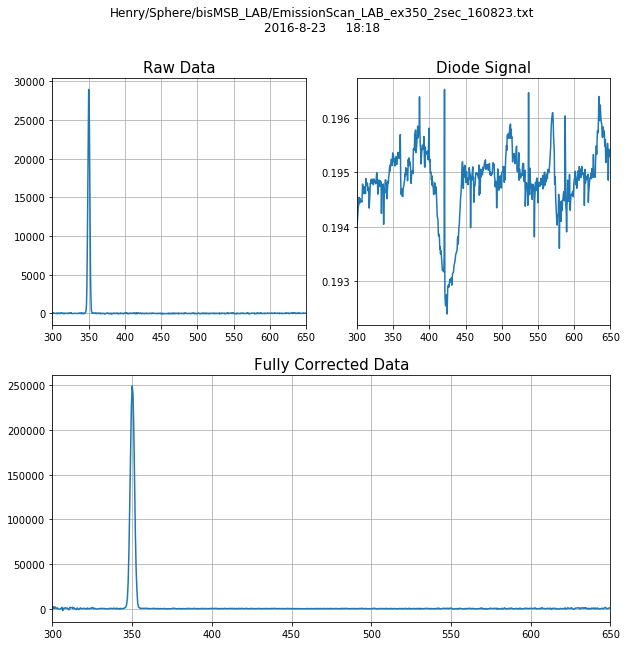

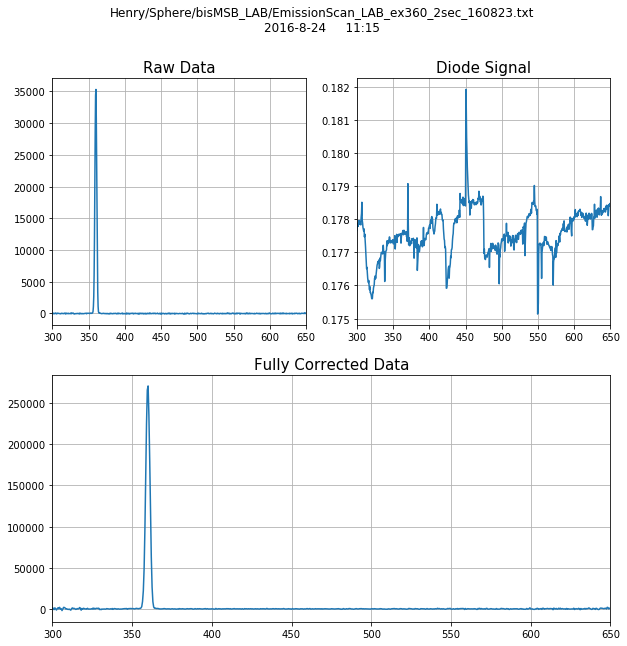

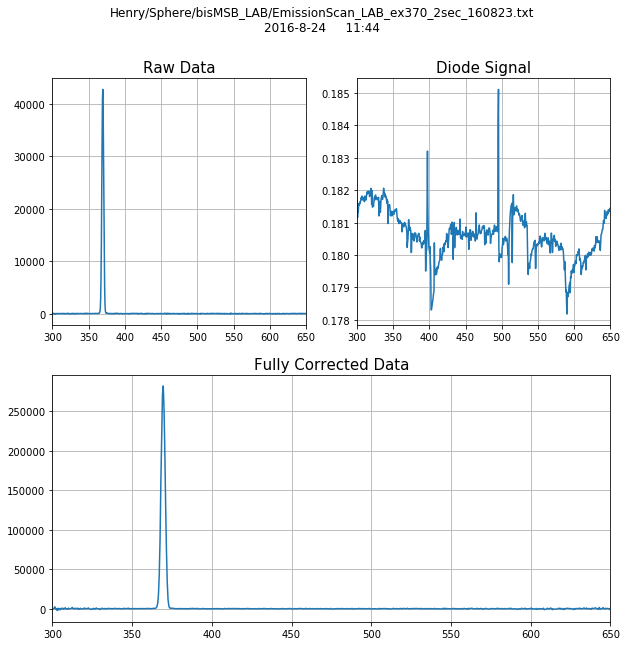

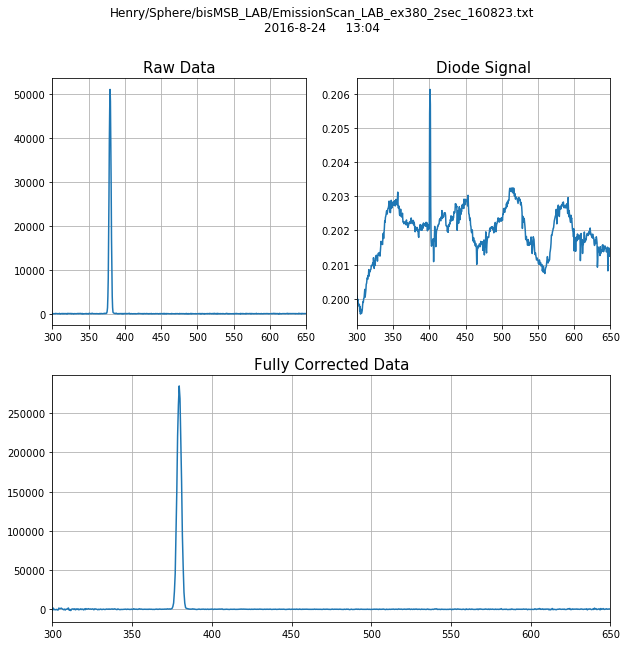

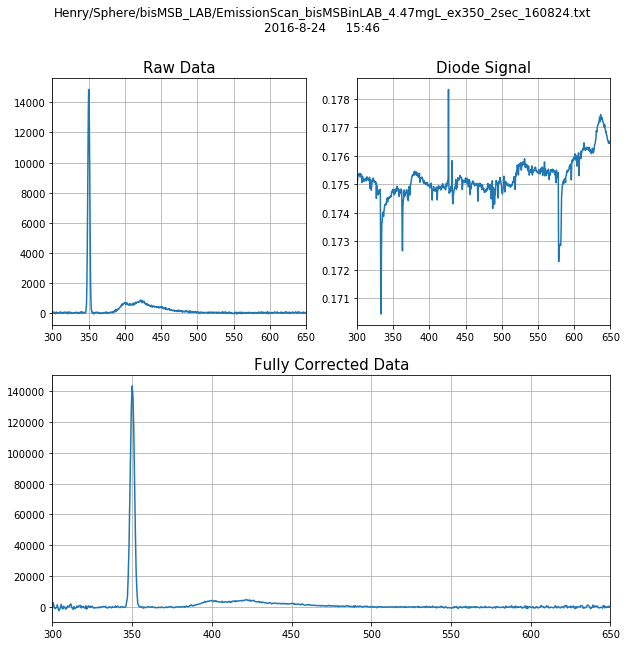

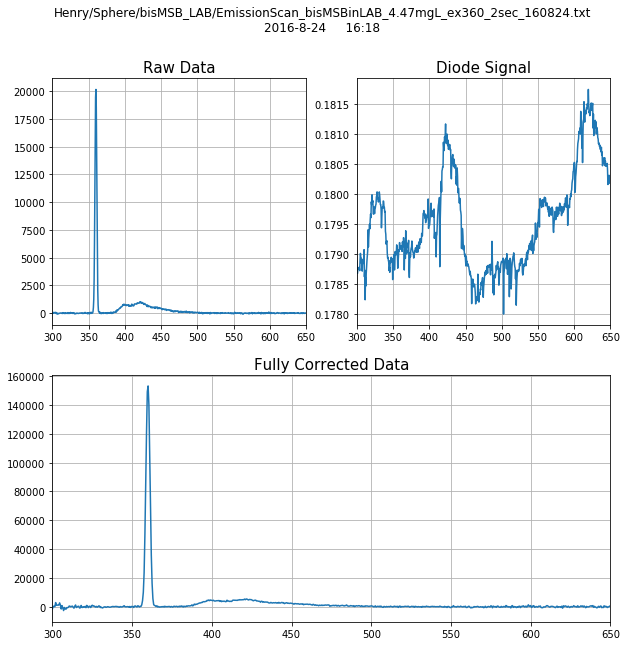

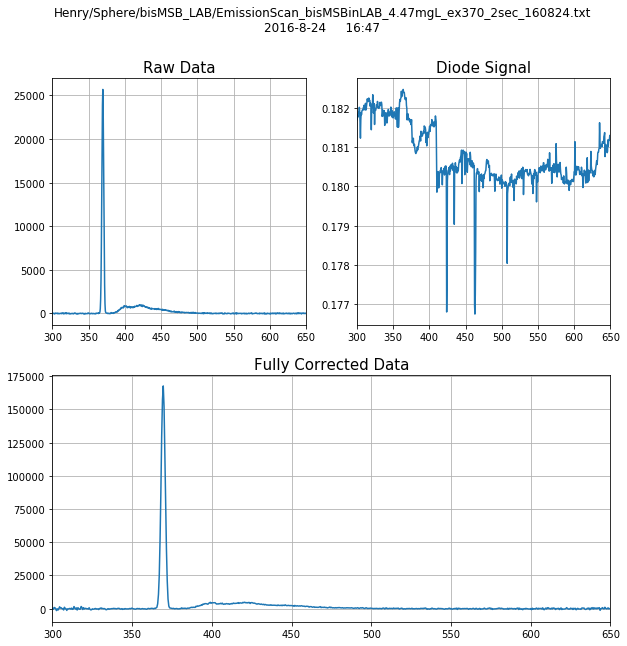

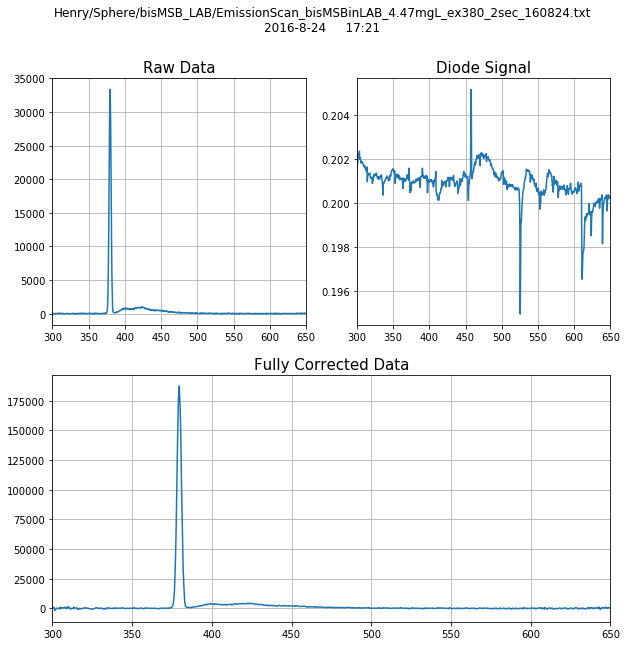

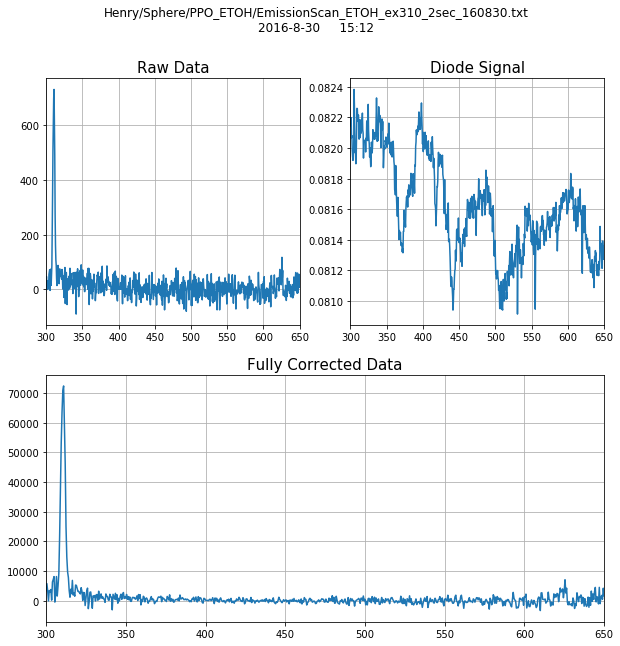

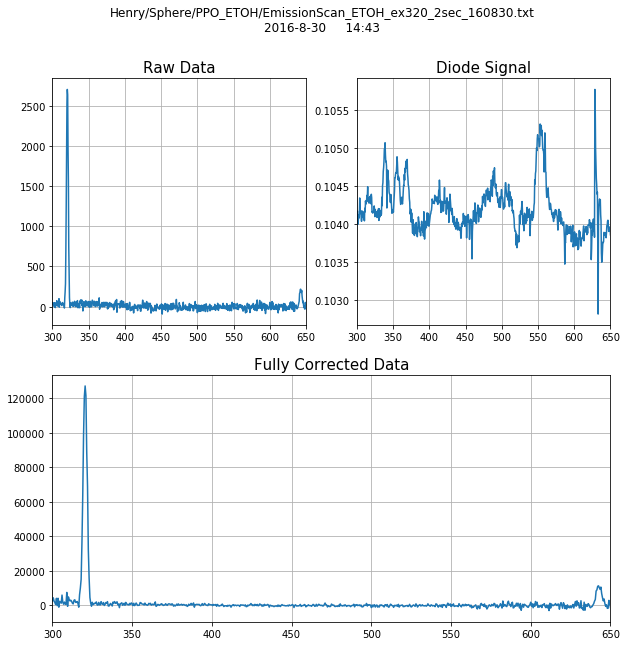

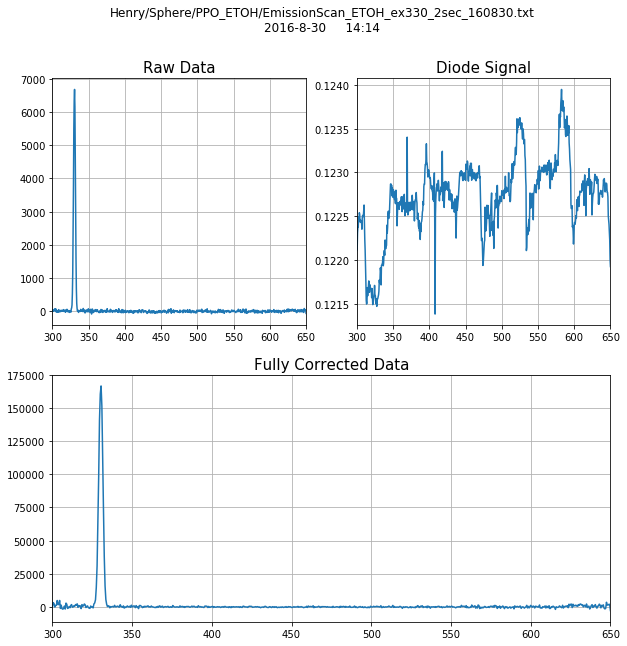

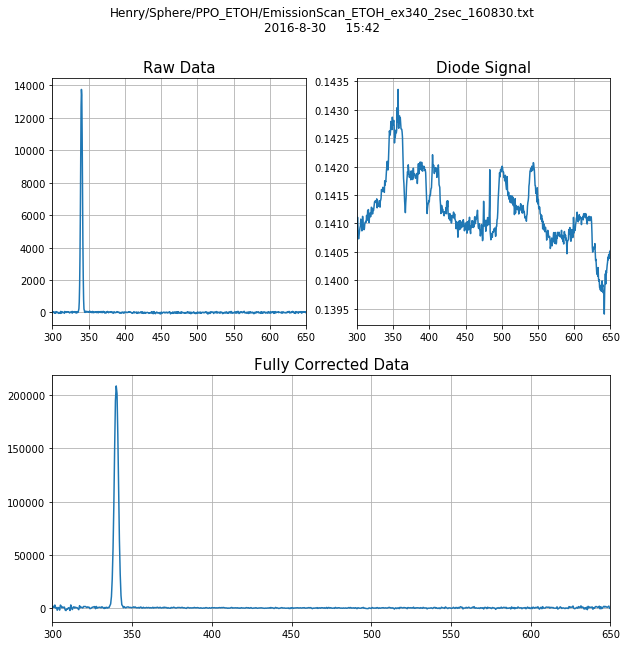

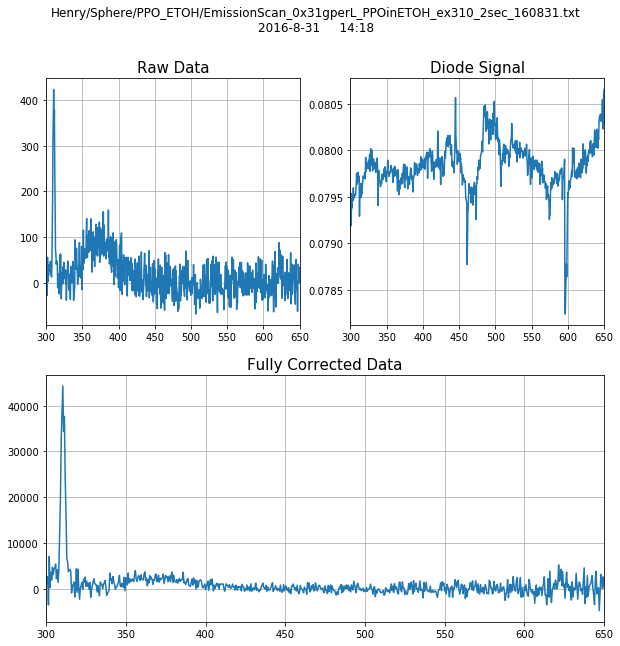

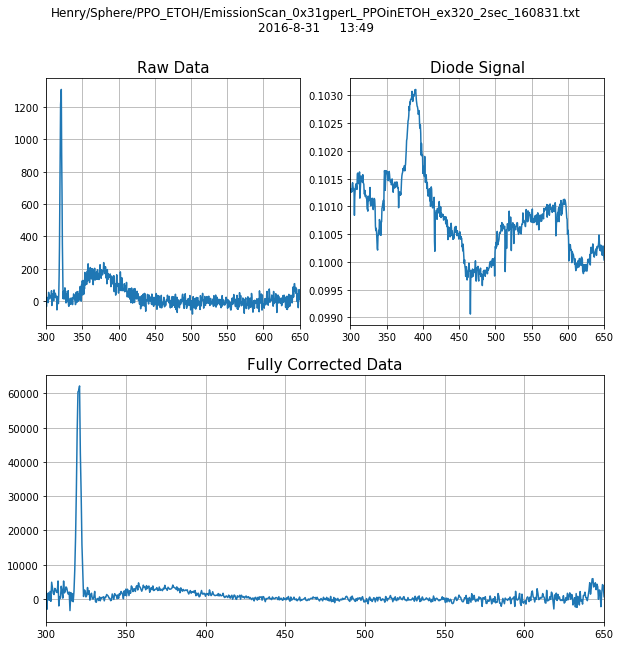

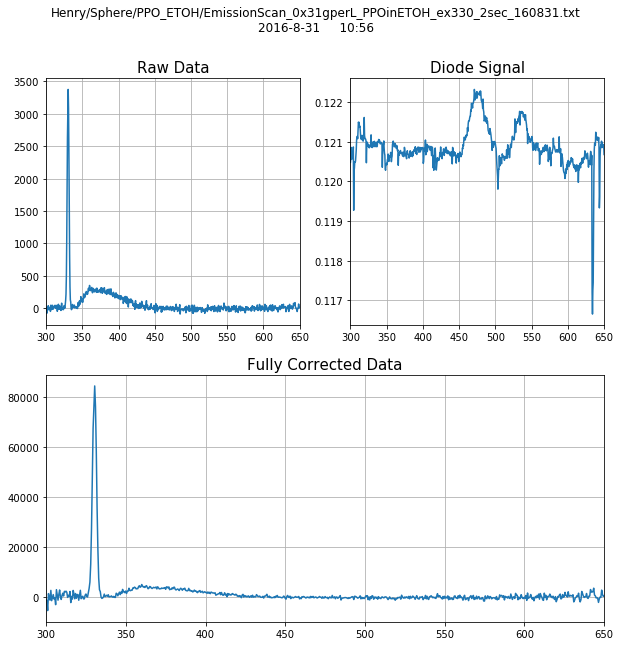

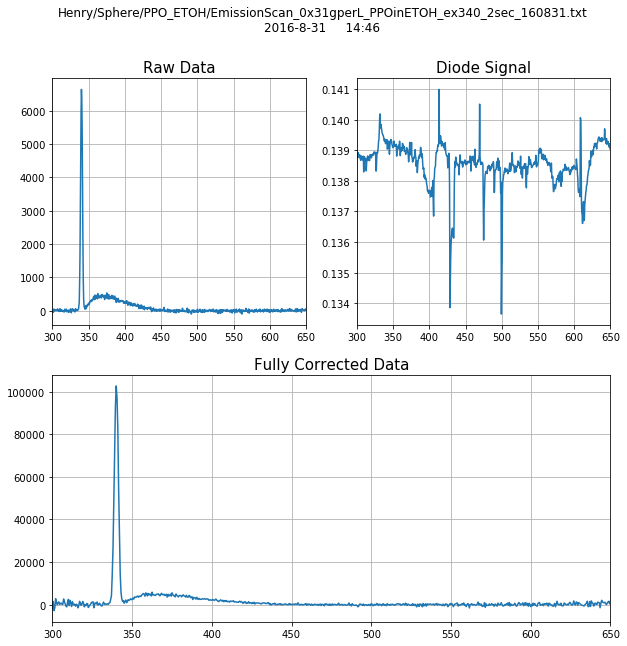

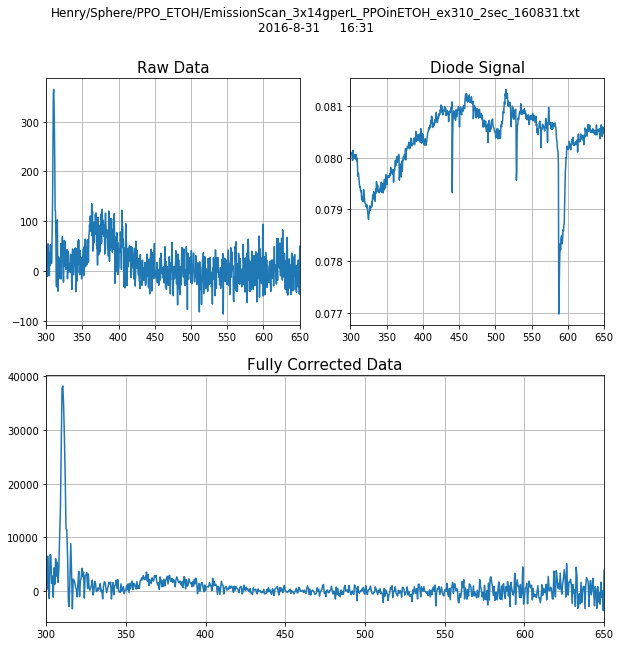

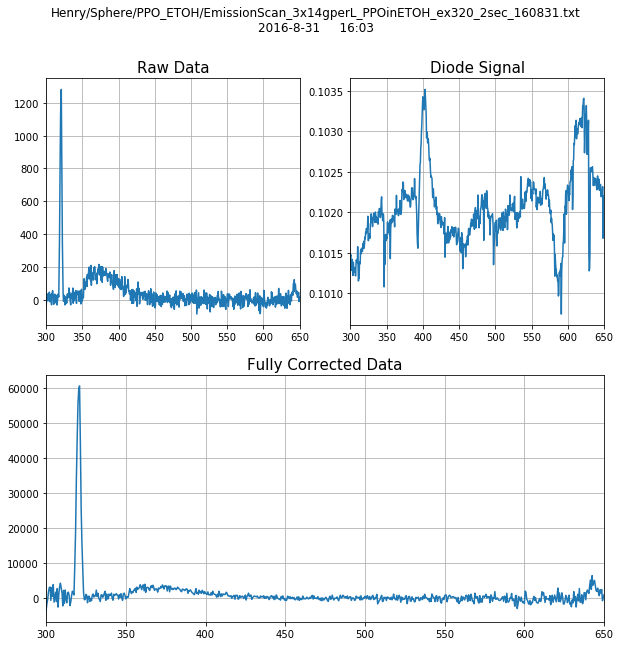

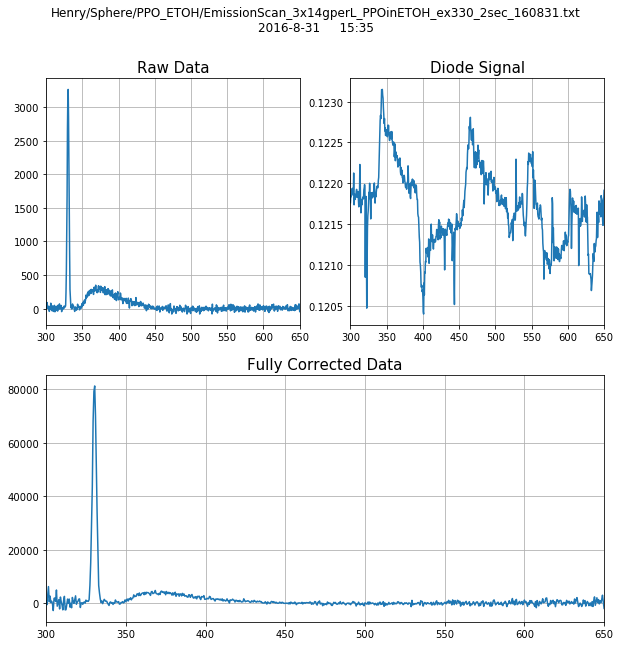

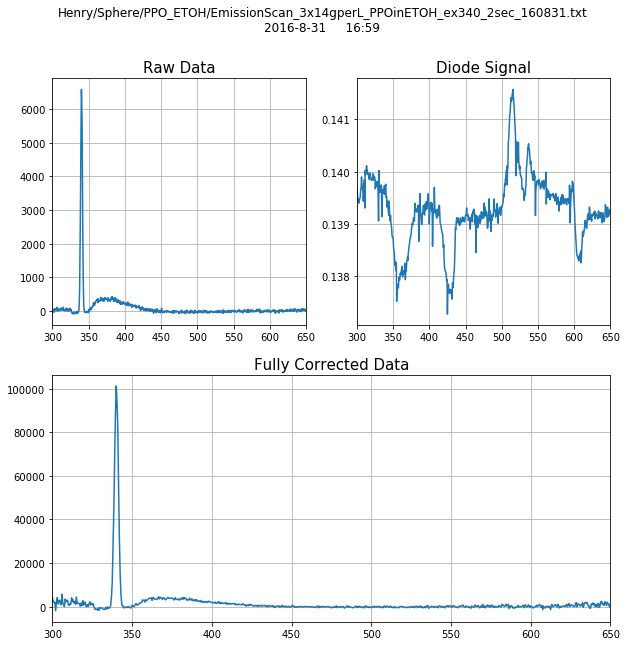

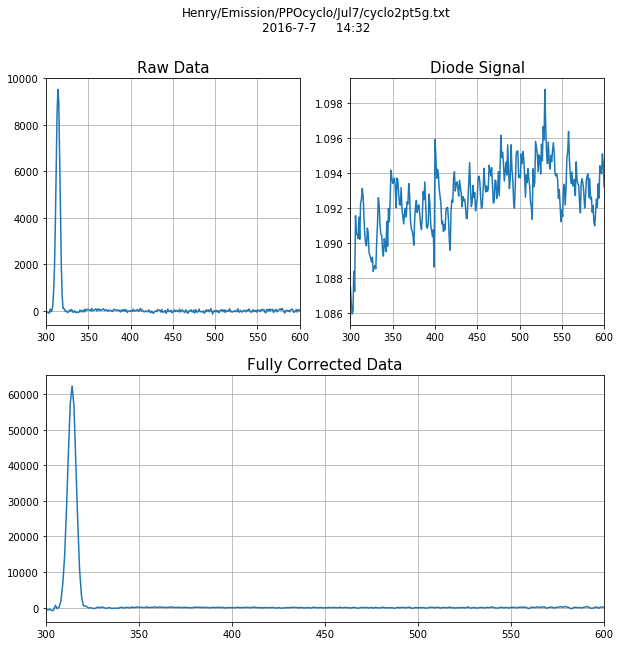

In [118]:
'''Quickly plot the data to examine the baseline and full corrections'''
for corrected in corrected_LAB + corrected_bisMSB_4x47 + corrected_ETOH + corrected_PPO_0x31 + corrected_PPO_3x14+corrected_cyclo:
#     break
    fig = corrected.plot()
    plt.show()
    plt.close(fig)

## 4.47 g/L bisMSB in LAB

In [ ]:
bisMSB_4x47_LAB_area_ratios = list()
bisMSB_4x47_LAB_QYs = list()

# Pair off the data sets into (blank, fluor pairs)
for blank, fluor in zip(corrected_LAB, corrected_bisMSB_4x47):
    # Define the integration region around the excitation wavelength
    ex_wavelength = blank.ex_range[0]
    ex_delta = 5
    ex_int_range = [ex_wavelength - ex_delta, ex_wavelength + ex_delta]
    
    # Define the emission region used for the quantum yield calculation
    em_int_range = [365, 650]
    
    # Define a second integration region away from the excitation spectrum so that we may perform corrections
    qy_correction_range = [400, 650]
    
    # Get the ratio between the two emission region integrals
    ratio =  PTIQY.integrate_between(fluor, blank, qy_correction_range)/ PTIQY.integrate_between(fluor, blank, em_int_range)
    bisMSB_4x47_LAB_area_ratios.append(ratio)
    
    # Calculate the raw quantum yield using the main integration regions 
    QY = PTIQY.calculate_QY(blank, fluor, ex_int_range, em_int_range)
    bisMSB_4x47_LAB_QYs.append(QY)
    
    # Plot the pairs together and highlight the integration region used for the raw QY
    fig = plt.figure(figsize = (16,10))
    ax0 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax2 = plt.subplot2grid((2,2), (1,1))
    
    fig.suptitle("Emission Spectra of 4.47 g/L bisMSB in LAB", fontsize = 20, y = 0.95)
    ax0.set_title("Calculated Quantum Yield = %0.3f" %QY, fontsize = 20)
    ax1.set_title("Absorption Range")
    ax2.set_title("Emission Range")
    
    for ax in[ax0, ax1, ax2]:
        ax.plot(blank.wavelengths, blank.cor_data, '#5f5474')
        ax.plot(fluor.wavelengths, fluor.cor_data, '#f03737')
        ax.grid()
    
    ex_limits_bool = (blank.wavelengths >= ex_int_range[0]) & (blank.wavelengths <= ex_int_range[1])
    em_limits_bool = (blank.wavelengths >= em_int_range[0]) & (blank.wavelengths <= em_int_range[1])
    ax1.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  ex_limits_bool, alpha=0.4)
    ax2.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  em_limits_bool, alpha=0.4)
    
    ax0.set_xlim(300, 650)
    ax1.set_xlim([0.99 * ex_int_range[0], 1.01 * ex_int_range[1]])
    ax2.set_xlim(360, 550)
    
    em_max = np.max(fluor.cor_data[np.where(fluor.wavelengths >= 390)])
    ax2.set_ylim(-0.2*em_max, 1.1*em_max)
    plt.show()
        

In [ ]:
print "Ratio of emission regrions for bisMSB spectrum\n",bisMSB_4x47_LAB_area_ratios 
integration_ratio = np.mean(bisMSB_4x47_LAB_area_ratios[:2])

print "\nIntegration ratio for 4.47 g/L bisMSB: %.4f" %integration_ratio

corrected_bisMSB_4x47_LAB_QYs = list()
for i in range(len(bisMSB_4x47_LAB_QYs)):
    corrected = (bisMSB_4x47_LAB_area_ratios[i] / integration_ratio * bisMSB_4x47_LAB_QYs[i])
    corrected_bisMSB_4x47_LAB_QYs.append(corrected)
    
print "\nCorrected quantum yields:\n", corrected_bisMSB_4x47_LAB_QYs

## 0.31 g/L PPO in EtOH

In [83]:
PPO_0x31_ETOH_area_ratios = list()
PPO_0x31_ETOH_QYs = list()

# Pair off the data sets into (blank, fluor pairs)
for blank, fluor in zip(corrected_ETOH, corrected_PPO_0x31):
    # Define the integration region around the excitation wavelength
    ex_wavelength = blank.ex_range[0]
    ex_delta = 10
    ex_int_range = [ex_wavelength - ex_delta, ex_wavelength + ex_delta]
    
    # Define the emission region used for the quantum yield calculation
    em_int_range = [320, 650]
    
    # Define a second integration region away from the excitation spectrum so that we may perform corrections
    qy_correction_range = [360, 650]
    
    # Get the ratio between the two emission region integrals
    ratio =  PTIQY.integrate_between(fluor, blank, qy_correction_range)/ PTIQY.integrate_between(fluor, blank, em_int_range)
    PPO_0x31_ETOH_area_ratios.append(ratio)
    
    # Calculate the raw quantum yield using the main integration regions 
    QY = PTIQY.calculate_QY(blank, fluor, ex_int_range, em_int_range)
    PPO_0x31_ETOH_QYs.append(QY)
    
    # Plot the pairs together and highlight the integration region used for the raw QY
    fig = plt.figure(figsize = (16,10))
    ax0 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax2 = plt.subplot2grid((2,2), (1,1))
    
    fig.suptitle("Emission Spectra of 0.31 g/L PPO in in EtOH", fontsize = 20, y = 0.95)
    ax0.set_title("Calculated Quantum Yield = %0.3f" %QY, fontsize = 20)
    ax1.set_title("Absorption Range")
    ax2.set_title("Emission Range")
    
    for ax in[ax0, ax1, ax2]:
        ax.plot(blank.wavelengths, blank.cor_data, '#5f5474')
        ax.plot(fluor.wavelengths, fluor.cor_data, '#f03737')
        ax.grid()
    
    ex_limits_bool = (blank.wavelengths >= ex_int_range[0]) & (blank.wavelengths <= ex_int_range[1])
    em_limits_bool = (blank.wavelengths >= em_int_range[0]) & (blank.wavelengths <= em_int_range[1])
    ax1.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  ex_limits_bool, alpha=0.4)
    ax2.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  em_limits_bool, alpha=0.4)
    
    ax0.set_xlim(300, 500)
    ax1.set_xlim([0.99 * ex_int_range[0], 1.01 * ex_int_range[1]])
    ax2.set_xlim(300, 450)
    
    em_max = np.max(fluor.cor_data[np.where(fluor.wavelengths >= 390)])
    ax2.set_ylim(-0.5*em_max, 1.5*em_max)
#     plt.show()
        

In [84]:
print "Ratio of emission regrions for PPO spectrum\n",PPO_0x31_ETOH_area_ratios
integration_ratio = np.mean(PPO_0x31_ETOH_area_ratios[:1])

print "\nIntegration ratio for 0.31 g/L PPO in EtOH: %.4f" %integration_ratio

corrected_PPO_0x31_ETOH_QYs = list()
for i in range(len(PPO_0x31_ETOH_QYs)):
    corrected = (PPO_0x31_ETOH_area_ratios[i] / integration_ratio * PPO_0x31_ETOH_QYs[i])
    corrected_PPO_0x31_ETOH_QYs.append(corrected)
    
print "\nCorrected quantum yields:\n", corrected_PPO_0x31_ETOH_QYs

Ratio of emission regrions for PPO spectrum
[0.99626526650546621, -106.77889137188119, -2.7993423643893793, -1.8990729930043331]

Integration ratio for 0.31 g/L PPO in EtOH: 0.9963

Corrected quantum yields:
[0.6154958240315026, 0.54521492114378989, 0.62949802737739358, 0.59010390769266896]


## 3.14 g/L PPO in EtOH

In [110]:
PPO_3x14_ETOH_area_ratios = list()
PPO_3x14_ETOH_QYs = list()

# Pair off the data sets into (blank, fluor pairs)
for blank, fluor in zip(corrected_ETOH, corrected_PPO_3x14):
    # Define the integration region around the excitation wavelength
    ex_wavelength = blank.ex_range[0]
    ex_delta = 10
    ex_int_range = [ex_wavelength - ex_delta, ex_wavelength + ex_delta]
    
    # Define the emission region used for the quantum yield calculation
    em_int_range = [320, 650]
    
    # Define a second integration region away from the excitation spectrum so that we may perform corrections
    qy_correction_range = [360, 650]
    
    # Get the ratio between the two emission region integrals
    ratio =  PTIQY.integrate_between(fluor, blank, qy_correction_range)/ PTIQY.integrate_between(fluor, blank, em_int_range)
    PPO_3x14_ETOH_area_ratios.append(ratio)
    
    # Calculate the raw quantum yield using the main integration regions 
    QY = PTIQY.calculate_QY(blank, fluor, ex_int_range, em_int_range)
    PPO_3x14_ETOH_QYs.append(QY)
    
    # Plot the pairs together and highlight the integration region used for the raw QY
    fig = plt.figure(figsize = (16,10))
    ax0 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax2 = plt.subplot2grid((2,2), (1,1))
    
    fig.suptitle("Emission Spectra of 0.31 g/L PPO in in EtOH", fontsize = 20, y = 0.95)
    ax0.set_title("Calculated Quantum Yield = %0.3f" %QY, fontsize = 20)
    ax1.set_title("Absorption Range")
    ax2.set_title("Emission Range")
    
    for ax in[ax0, ax1, ax2]:
        ax.plot(blank.wavelengths, blank.cor_data, '#5f5474')
        ax.plot(fluor.wavelengths, fluor.cor_data, '#f03737')
        ax.grid()
    
    ex_limits_bool = (blank.wavelengths >= ex_int_range[0]) & (blank.wavelengths <= ex_int_range[1])
    em_limits_bool = (blank.wavelengths >= em_int_range[0]) & (blank.wavelengths <= em_int_range[1])
    ax1.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  ex_limits_bool, alpha=0.4)
    ax2.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  em_limits_bool, alpha=0.4)
    
    ax0.set_xlim(300, 650)
    ax1.set_xlim([0.99 * ex_int_range[0], 1.01 * ex_int_range[1]])
    ax2.set_xlim(300, 500)
    
    em_max = np.max(fluor.cor_data[np.where(fluor.wavelengths >= 390)])
    ax2.set_ylim(-0.5*em_max, 1.5*em_max)
#     plt.show()
        

In [111]:
print "Ratio of emission regrions for bisMSB spectrum\n",PPO_3x14_ETOH_area_ratios
integration_ratio = np.mean(PPO_3x14_ETOH_area_ratios[:1])

print "\nIntegration ratio for 0.31 g/L PPO in EtOH: %.4f" %integration_ratio

corrected_PPO_3x14_ETOH_QYs = list()
for i in range(len(PPO_3x14_ETOH_QYs)):
    corrected = (PPO_3x14_ETOH_area_ratios[i] / integration_ratio * PPO_3x14_ETOH_QYs[i])
    corrected_PPO_3x14_ETOH_QYs.append(corrected)
    
print "\nCorrected quantum yields:\n", corrected_PPO_3x14_ETOH_QYs

Ratio of emission regrions for bisMSB spectrum
[1.0820161806628656, -4.7984616125388815, -1.9072658312821793, -0.89512832523790797]

Integration ratio for 0.31 g/L PPO in EtOH: 1.0820

Corrected quantum yields:
[0.43530907475386432, 0.43209642319759511, 0.56056679901126727, 0.42367738189284448]


## Various Concentrations of PPO in Cyclohexane

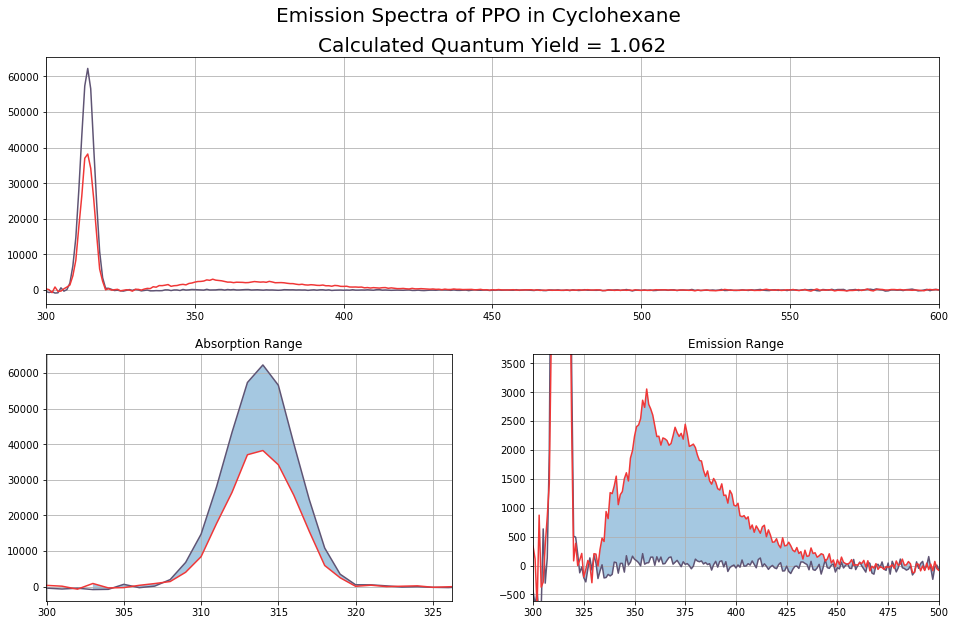

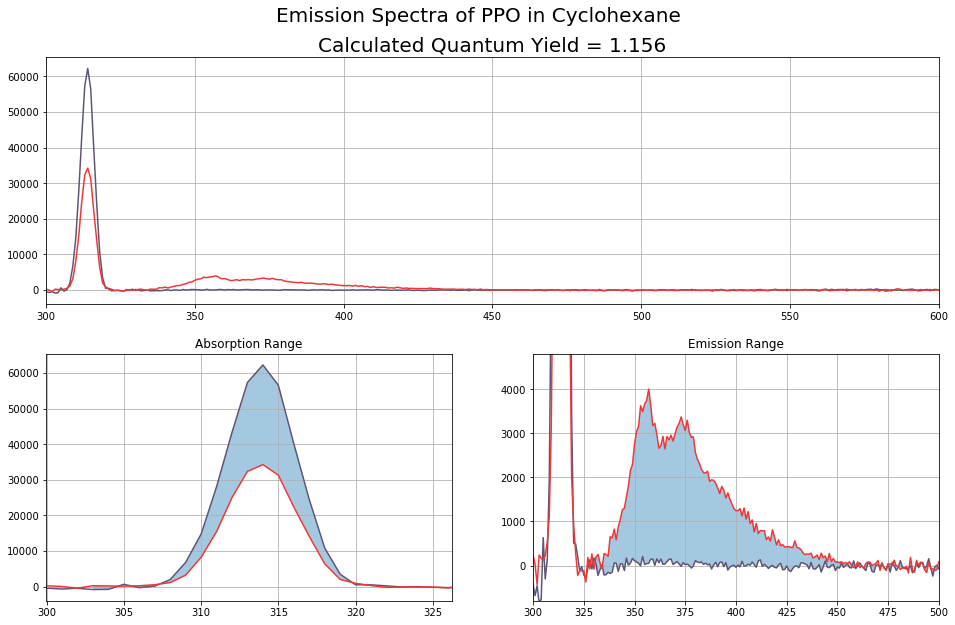

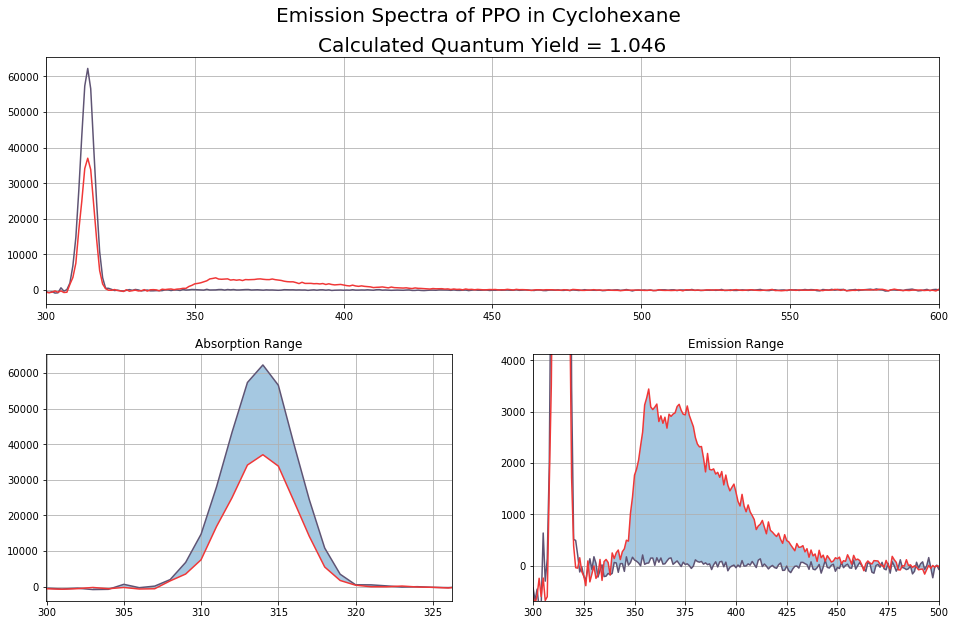

In [117]:
PPO_cyclo_area_ratios = list()
PPO_cyclo_QYs = list()

# Pair off the data sets into (blank, fluor pairs)
for blank, fluor in zip(len(PPO_cyclo)*corrected_cyclo, corrected_PPO_cyclo):
    # Define the integration region around the excitation wavelength
    ex_wavelength = blank.ex_range[0]
    ex_delta = 10
    ex_int_range = [ex_wavelength - ex_delta, ex_wavelength + ex_delta]
    
    # Define the emission region used for the quantum yield calculation
    em_int_range = [325, 600]
    
    # Define a second integration region away from the excitation spectrum so that we may perform corrections
    qy_correction_range = [370, 600]
    
    # Get the ratio between the two emission region integrals
    ratio =  PTIQY.integrate_between(fluor, blank, qy_correction_range)/ PTIQY.integrate_between(fluor, blank, em_int_range)
    PPO_cyclo_area_ratios.append(ratio)
    
    # Calculate the raw quantum yield using the main integration regions 
    QY = PTIQY.calculate_QY(blank, fluor, ex_int_range, em_int_range)
    PPO_cyclo_QYs.append(QY)
    
    # Plot the pairs together and highlight the integration region used for the raw QY
    fig = plt.figure(figsize = (16,10))
    ax0 = plt.subplot2grid((2,2), (0,0), colspan = 2)
    ax1 = plt.subplot2grid((2,2), (1,0))
    ax2 = plt.subplot2grid((2,2), (1,1))
    
    fig.suptitle("Emission Spectra of PPO in Cyclohexane", fontsize = 20, y = 0.95)
    ax0.set_title("Calculated Quantum Yield = %0.3f" %QY, fontsize = 20)
    ax1.set_title("Absorption Range")
    ax2.set_title("Emission Range")
    
    for ax in[ax0, ax1, ax2]:
        ax.plot(blank.wavelengths, blank.cor_data, '#5f5474')
        ax.plot(fluor.wavelengths, fluor.cor_data, '#f03737')
        ax.grid()
    
    ex_limits_bool = (blank.wavelengths >= ex_int_range[0]) & (blank.wavelengths <= ex_int_range[1])
    em_limits_bool = (blank.wavelengths >= em_int_range[0]) & (blank.wavelengths <= em_int_range[1])
    ax1.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  ex_limits_bool, alpha=0.4)
    ax2.fill_between(blank.wavelengths, blank.cor_data, fluor.cor_data,  em_limits_bool, alpha=0.4)
    
    ax0.set_xlim(300, 600)
    ax1.set_xlim([0.99 * ex_int_range[0], 1.01 * ex_int_range[1]])
    ax2.set_xlim(300, 500)
    
    em_max = np.max(fluor.cor_data[np.where(fluor.wavelengths >= 320)])
    ax2.set_ylim(-0.2*em_max, 1.2*em_max)
    plt.show()

In [116]:
print "Ratio of emission regrions for bisMSB spectrum\n",PPO_cyclo_area_ratios
integration_ratio = np.mean(PPO_cyclo_area_ratios[:2])

print "\nIntegration ratio for 0.31 g/L PPO in EtOH: %.4f" %integration_ratio

corrected_PPO_cyclo_QYs = list()
for i in range(len(PPO_cyclo_QYs)):
    corrected = (PPO_cyclo_area_ratios[i] / integration_ratio * PPO_cyclo_QYs[i])
    corrected_PPO_cyclo_QYs.append(corrected)
    
print "\nCorrected quantum yields:\n", corrected_PPO_cyclo_QYs

Ratio of emission regrions for bisMSB spectrum
[0.50670369241703961, 0.54089669599272239, 0.60893371872711199]

Integration ratio for 0.31 g/L PPO in EtOH: 0.5238

Corrected quantum yields:
[1.0601655230541154, 1.1924363304339294, 1.2125571121667231]
